## Extensions - Anomaly Detection Algorithm

### Exploring the train batch `batch146_17`

In [2]:
import os
from src.config import get_project_root
ROOT_DIR = get_project_root()
import pandas as pd
import seaborn as sns
df = pd.read_csv(os.path.join(ROOT_DIR, 'data/clean/batch146_17_clean.csv'))
df.head()
df.label.value_counts()

0    37967
1     5265
Name: label, dtype: int64

/Users/mm12574/miniconda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='1_diff_avg_jvm_heap_used_value', ylabel='1_diff_driver_StreamingMetrics_streaming_totalReceivedRecords_value'>

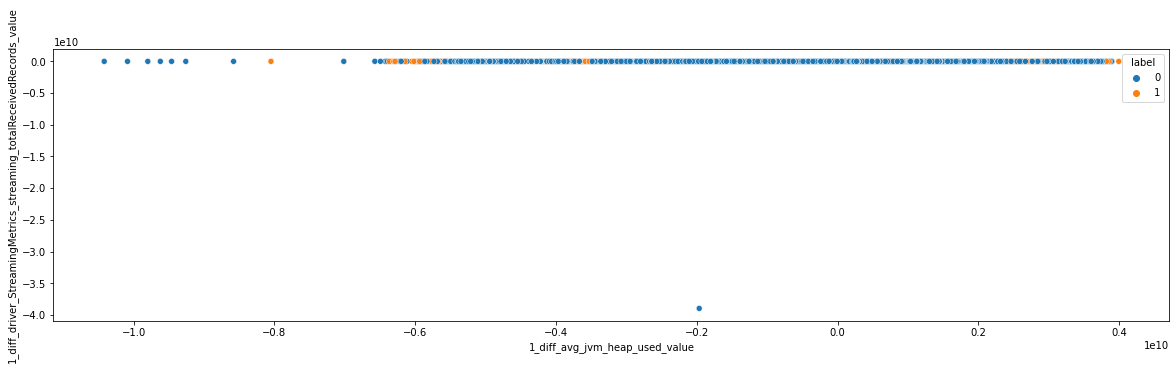

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
sns.scatterplot(df['1_diff_avg_jvm_heap_used_value'],
                df['1_diff_driver_StreamingMetrics_streaming_totalReceivedRecords_value'],
                hue=df['label'])

### Preprocessing the data

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = df.iloc[:, 1:-1]
y = df.label.values.ravel()
X_scaled = scaler.fit_transform(X)

In [7]:
# Train, test, validation split
# Unseen test set: 15%
# Validation set: (0.85*0.15) = 12.75%
# Train set 72.25%

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.20, random_state=9821)

print('Shape of X_test:', X_test.shape,';', 'Abnormal percentage:', round(sum(y_test)/len(y_test),3))
print('Shape of X_train:', X_train.shape,';', 'Abnormal percentage:', round(sum(y_train)/len(y_train),3))

Shape of X_test: (8647, 20) ; Abnormal percentage: 0.12
Shape of X_train: (34585, 20) ; Abnormal percentage: 0.122


### Model building

#### XGBoost

[12:27:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.9891291777495085
F1 score: 0.952952952952953
Recall: 0.9171483622350675
Precision: 0.9916666666666667

 clasification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      7609
           1       0.99      0.92      0.95      1038

    accuracy                           0.99      8647
   macro avg       0.99      0.96      0.97      8647
weighted avg       0.99      0.99      0.99      8647


 confussion matrix:
 [[7601    8]
 [  86  952]]


NameError: name 'plt' is not defined

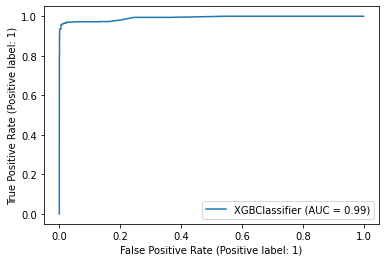

In [8]:
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, confusion_matrix, \
    classification_report, accuracy_score, f1_score

xgb = XGBClassifier(use_label_encoder=False, random_state=9821, learning_rate=0.01)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('\n clasification report:\n', classification_report(y_test, y_pred))
print('\n confussion matrix:\n',confusion_matrix(y_test, y_pred))
metrics.plot_roc_curve(xgb, X_test, y_test)
plt.show()

from xgboost import plot_importance
from matplotlib import pyplot

# plot feature importance
plot_importance(xgb)
pyplot.show()
#xgb.feature_importances_

In [25]:
X.columns

Index(['driver_StreamingMetrics_streaming_lastCompletedBatch_processingDelay_value',
       'driver_StreamingMetrics_streaming_lastCompletedBatch_schedulingDelay_value',
       'driver_StreamingMetrics_streaming_lastCompletedBatch_totalDelay_value',
       '1_diff_driver_StreamingMetrics_streaming_totalCompletedBatches_value',
       '1_diff_driver_StreamingMetrics_streaming_totalProcessedRecords_value',
       '1_diff_driver_StreamingMetrics_streaming_totalReceivedRecords_value',
       '1_diff_driver_StreamingMetrics_streaming_lastReceivedBatch_records_value',
       '1_diff_driver_BlockManager_memory_memUsed_MB_value',
       '1_diff_driver_jvm_heap_used_value', '1_diff_node5_CPU_ALL_Idle%',
       '1_diff_node6_CPU_ALL_Idle%', '1_diff_node7_CPU_ALL_Idle%',
       '1_diff_node8_CPU_ALL_Idle%',
       '1_diff_avg_executor_filesystem_hdfs_write_ops_value',
       '1_diff_avg_executor_cpuTime_count',
       '1_diff_avg_executor_runTime_count',
       '1_diff_avg_executor_shuffleRecords

#### Random forest

In [ ]:
"""
# Don't rerun, take a lot of time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
rf = RandomForestClassifier(random_state=9821)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)
"""

In [73]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

In [9]:
# Use the best parameters to build the random forest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, \
    classification_report, accuracy_score, f1_score
rf = RandomForestClassifier(random_state=9821)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('\n clasification report:\n', classification_report(y_test, y_pred))
print('\n confussion matrix:\n',confusion_matrix(y_test, y_pred))

Accuracy: 0.9893604718399445
F1 score: 0.9542743538767395
Recall: 0.9248554913294798
Precision: 0.9856262833675564

 clasification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      7609
           1       0.99      0.92      0.95      1038

    accuracy                           0.99      8647
   macro avg       0.99      0.96      0.97      8647
weighted avg       0.99      0.99      0.99      8647


 confussion matrix:
 [[7595   14]
 [  78  960]]


#### Neural Networks

In [51]:
from tensorflow import keras
model = keras.Sequential(
 [
 keras.layers.Dense(64, activation="relu", input_shape=(X_train.shape[-1],)),
 #keras.layers.BatchNormalization(),
 keras.layers.Dense(128, activation="relu"),
 keras.layers.Dropout(0.1),
 keras.layers.Dense(256, activation="relu"),
 keras.layers.BatchNormalization(),
 keras.layers.Dropout(0.2),
 keras.layers.Dense(1, activation="sigmoid"),
 ]
)
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 64)                1344      
_________________________________________________________________
dense_69 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_34 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_18 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_35 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 1)               

In [59]:
import tensorflow.keras.backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(
 optimizer=keras.optimizers.Adam(9e-3),
 loss="binary_crossentropy",
 metrics=[f1_m]
)

history = model.fit(
 X_train,
 y_train,
 batch_size=2048,
 epochs=10,
 verbose=2,
 validation_split = 0.2)

Epoch 1/10
14/14 - 1s - loss: 0.0332 - f1_m: 0.9525 - val_loss: 0.0640 - val_f1_m: 0.9181
Epoch 2/10
14/14 - 0s - loss: 0.0301 - f1_m: 0.9527 - val_loss: 0.0595 - val_f1_m: 0.9275
Epoch 3/10
14/14 - 0s - loss: 0.0243 - f1_m: 0.9624 - val_loss: 0.0577 - val_f1_m: 0.9232
Epoch 4/10
14/14 - 0s - loss: 0.0289 - f1_m: 0.9601 - val_loss: 0.0656 - val_f1_m: 0.9100
Epoch 5/10
14/14 - 0s - loss: 0.0268 - f1_m: 0.9624 - val_loss: 0.0514 - val_f1_m: 0.9442
Epoch 6/10
14/14 - 0s - loss: 0.0226 - f1_m: 0.9659 - val_loss: 0.0558 - val_f1_m: 0.9349
Epoch 7/10
14/14 - 0s - loss: 0.0222 - f1_m: 0.9676 - val_loss: 0.0562 - val_f1_m: 0.9337
Epoch 8/10
14/14 - 0s - loss: 0.0218 - f1_m: 0.9692 - val_loss: 0.0573 - val_f1_m: 0.9418
Epoch 9/10
14/14 - 0s - loss: 0.0218 - f1_m: 0.9689 - val_loss: 0.0603 - val_f1_m: 0.9378
Epoch 10/10
14/14 - 0s - loss: 0.0245 - f1_m: 0.9648 - val_loss: 0.0573 - val_f1_m: 0.9335


In [60]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, \
    classification_report, accuracy_score, f1_score

y_pred = (model.predict(X_test)>0.5).astype('uint8')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('\n clasification report:\n', classification_report(y_test, y_pred))
print('\n confussion matrix:\n',confusion_matrix(y_test, y_pred))

Accuracy: 0.9861223545738407
F1 score: 0.9419729206963249
Recall: 0.9383429672447013
Precision: 0.945631067961165

 clasification report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      7609
           1       0.95      0.94      0.94      1038

    accuracy                           0.99      8647
   macro avg       0.97      0.97      0.97      8647
weighted avg       0.99      0.99      0.99      8647


 confussion matrix:
 [[7553   56]
 [  64  974]]


### Use the ML models to predict the test datasets `batch146_18`, `batch146_15` and `batch146_13`

- Train model on `batch146_19` and predict on `batch146_18`
- Train model on `batch146_20` and predict on `batch146_15`
- Train model on `batch146_17` and predict on `batch146_13`
- Save the predictions under `data/ML_preds`


In [56]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, confusion_matrix, \
    classification_report, accuracy_score, f1_score
from xgboost import XGBClassifier
path_MLpreds = 'data/MLpreds'

scaler = StandardScaler()
df = pd.read_csv(os.path.join(ROOT_DIR, 'data/clean/batch146_17_clean.csv'))
X = df.iloc[:, 1:-1]
y_train = df.label.values.ravel()
X_train = scaler.fit_transform(X)
df_test = pd.read_csv(os.path.join(ROOT_DIR, 'data/clean/batch146_13_clean.csv'))
X_test_raw = df_test[df_test.columns.drop('t')]
X_test = scaler.fit_transform(X_test_raw)

xgb = XGBClassifier(use_label_encoder=False,
                    random_state=9821,
                    learning_rate=0.07,
                    max_depth=6)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_train)
#y_pred = (model.predict(X_train)>0.5).astype('uint8')
print('Accuracy:', accuracy_score(y_train, y_pred))
print('F1 score:', f1_score(y_train, y_pred))
print('Recall:', recall_score(y_train, y_pred))
print('Precision:', precision_score(y_train, y_pred))
print('\n clasification report:\n', classification_report(y_train, y_pred))
print('\n confussion matrix:\n',confusion_matrix(y_train, y_pred))

df_test['label'] = xgb.predict(X_test)
df_test.to_csv(os.path.join(ROOT_DIR, path_MLpreds, 'batch146_13.csv'), index=False)

[21:34:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.9999537379718727
F1 score: 0.9998100303951368
Recall: 0.9996201329534663
Precision: 1.0

 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     37967
           1       1.00      1.00      1.00      5265

    accuracy                           1.00     43232
   macro avg       1.00      1.00      1.00     43232
weighted avg       1.00      1.00      1.00     43232


 confussion matrix:
 [[37967     0]
 [    2  5263]]


/Users/mm12574/miniconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/mm12574/miniconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [4]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, confusion_matrix, \
    classification_report, accuracy_score, f1_score
from xgboost import XGBClassifier
path_MLpreds = 'data/MLpreds'

scaler = StandardScaler()
df = pd.read_csv(os.path.join(ROOT_DIR, 'data/clean/batch146_19_clean.csv'))
X = df.iloc[:, 1:-1]
y_train = df.label.values.ravel()
X_train = scaler.fit_transform(X)
df_test = pd.read_csv(os.path.join(ROOT_DIR, 'data/clean/batch146_18_clean.csv'))
X_test_raw = df_test[df_test.columns.drop('t')]
X_test = scaler.fit_transform(X_test_raw)

xgb = XGBClassifier(use_label_encoder=False,
                    random_state=9821,
                    learning_rate=0.07,
                    max_depth=6)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_train)
#y_pred = (model.predict(X_train)>0.5).astype('uint8')
print('Accuracy:', accuracy_score(y_train, y_pred))
print('F1 score:', f1_score(y_train, y_pred))
print('Recall:', recall_score(y_train, y_pred))
print('Precision:', precision_score(y_train, y_pred))
print('\n clasification report:\n', classification_report(y_train, y_pred))
print('\n confussion matrix:\n',confusion_matrix(y_train, y_pred))

df_test['label'] = xgb.predict(X_test)
df_test.to_csv(os.path.join(ROOT_DIR, path_MLpreds, 'batch146_18.csv'), index=False)

[22:38:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.9996067545685866
F1 score: 0.9983801810385898
Recall: 0.996765601217656
Precision: 1.0

 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     37974
           1       1.00      1.00      1.00      5256

    accuracy                           1.00     43230
   macro avg       1.00      1.00      1.00     43230
weighted avg       1.00      1.00      1.00     43230


 confussion matrix:
 [[37974     0]
 [   17  5239]]


/Users/mm12574/miniconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/mm12574/miniconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [3]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, confusion_matrix, \
    classification_report, accuracy_score, f1_score
from xgboost import XGBClassifier
path_MLpreds = 'data/MLpreds'

scaler = StandardScaler()
df = pd.read_csv(os.path.join(ROOT_DIR, 'data/clean/batch146_20_clean.csv'))
X = df.iloc[:, 1:-1]
y_train = df.label.values.ravel()
X_train = scaler.fit_transform(X)
df_test = pd.read_csv(os.path.join(ROOT_DIR, 'data/clean/batch146_15_clean.csv'))
X_test_raw = df_test[df_test.columns.drop('t')]
X_test = scaler.fit_transform(X_test_raw)

xgb = XGBClassifier(use_label_encoder=False,
                    random_state=9821,
                    learning_rate=0.07,
                    max_depth=6)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_train)
#y_pred = (model.predict(X_train)>0.5).astype('uint8')
print('Accuracy:', accuracy_score(y_train, y_pred))
print('F1 score:', f1_score(y_train, y_pred))
print('Recall:', recall_score(y_train, y_pred))
print('Precision:', precision_score(y_train, y_pred))
print('\n clasification report:\n', classification_report(y_train, y_pred))
print('\n confussion matrix:\n',confusion_matrix(y_train, y_pred))

df_test['label'] = xgb.predict(X_test)
df_test.to_csv(os.path.join(ROOT_DIR, path_MLpreds, 'batch146_15.csv'), index=False)

[22:37:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.9996993037725811
F1 score: 0.9987498797961342
Recall: 0.9975028812908183
Precision: 1.0

 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     38027
           1       1.00      1.00      1.00      5206

    accuracy                           1.00     43233
   macro avg       1.00      1.00      1.00     43233
weighted avg       1.00      1.00      1.00     43233


 confussion matrix:
 [[38027     0]
 [   13  5193]]


/Users/mm12574/miniconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/mm12574/miniconda/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
